In [52]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix, kde_1d
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

### Setting up the pyabc run

In [7]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=17, threads_per_worker = 2)
client = Client(c,timeout=90)

In [8]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'0_4_Adults_mean': 17152.0,
 '10_4_Adults_mean': 14350.0,
 '20_4_Adults_mean': 11823.0,
 '40_4_Adults_mean': 12679.0,
 '80_4_Adults_mean': 12095.0,
 '160_4_Adults_mean': 11954.0,
 '0_5_Adults_mean': 19216.0,
 '10_5_Adults_mean': 17330.0,
 '20_5_Adults_mean': 15110.0,
 '40_5_Adults_mean': 10917.0,
 '80_5_Adults_mean': 7923.0,
 '160_5_Adults_mean': 5980.0,
 '0_6_Adults_mean': 18229.0,
 '10_6_Adults_mean': 17481.0,
 '20_6_Adults_mean': 17078.0,
 '40_6_Adults_mean': 15322.0,
 '80_6_Adults_mean': 6599.0,
 '160_6_Adults_mean': 2245.0,
 '0_7_Adults_mean': 12589.0,
 '10_7_Adults_mean': 14229.0,
 '20_7_Adults_mean': 18951.0,
 '40_7_Adults_mean': 17520.0,
 '80_7_Adults_mean': 16514.0,
 '160_7_Adults_mean': 478.0,
 '0_4_Adults_sd': 3874.0,
 '10_4_Adults_sd': 5023.0,
 '20_4_Adults_sd': 4745.0,
 '40_4_Adults_sd': 5132.0,
 '80_4_Adults_sd': 4682.0,
 '160_4_Adults_sd': 3807.0,
 '0_5_Adults_sd': 4729.0,
 '10_5_Adults_sd': 3807.0,
 '20_5_Adults_sd': 5023.0,
 '40_5_Adults_sd': 4847.0,
 '80_5_Adults_sd'

In [9]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #transformed to 0.0001 - .1
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              #AIAdultLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AIAdultLD50=(-4, -1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AIAdultSlope=(1, 9),
              #AILarvaLD50=(math.log10(.0001), math.log10(.5)), #units are ug/bee. Equiv to .1 ng/bee to 1000 ng/bee
              AILarvaLD50=(-4,-1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [10]:
# Set our distance function and sampler
distance = pyabc.AdaptivePNormDistance(p=2, adaptive=True, scale_type=0) #scale type is MAD (more resilient to outliers)
#df_logger = logging.getLogger('DistanceFunction')
#df_logger.setLevel(logging.DEBUG)

#distance = PNormDistance(p=2)

sampler = DaskDistributedSampler(dask_client = client)
#sampler = SingleCoreSampler()

transition = LocalTransition()

In [11]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=100,#AdaptivePopulationSize(500, max_population_size = 600),
             transitions = transition,
             sampler=sampler)

In [12]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_20.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=2, start_time=2018-11-20 16:50:58.666070, end_time=None)>
INFO:Epsilon:initial epsilon is 43915.90177067722


2

In [13]:
history = abc.run(max_nr_populations=4, minimum_epsilon=0)

INFO:ABC:t:0 eps:43915.90177067722
INFO:ABC:t:1 eps:43194.339305688816
INFO:ABC:t:2 eps:37589.93333915255
INFO:ABC:t:3 eps:44708.09245494654
INFO:History:Done <ABCSMC(id=2, start_time=2018-11-20 16:50:58.666070, end_time=2018-11-21 05:07:04.583930)>


In [35]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-20 16:51:01.530900,0,0.000000,1
1,0,2018-11-20 20:17:45.438837,208,43915.901771,100
2,1,2018-11-20 22:48:37.583024,238,43194.339306,100
3,2,2018-11-21 02:17:30.882051,366,37589.933339,100
4,3,2018-11-21 05:06:52.668474,251,44708.092455,100


In [36]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}".format(gen+1,particles/samples*100))

Acceptance rates
Gen 1: 48.1
Gen 2: 42.0
Gen 3: 27.3
Gen 4: 39.8


### Visualize results

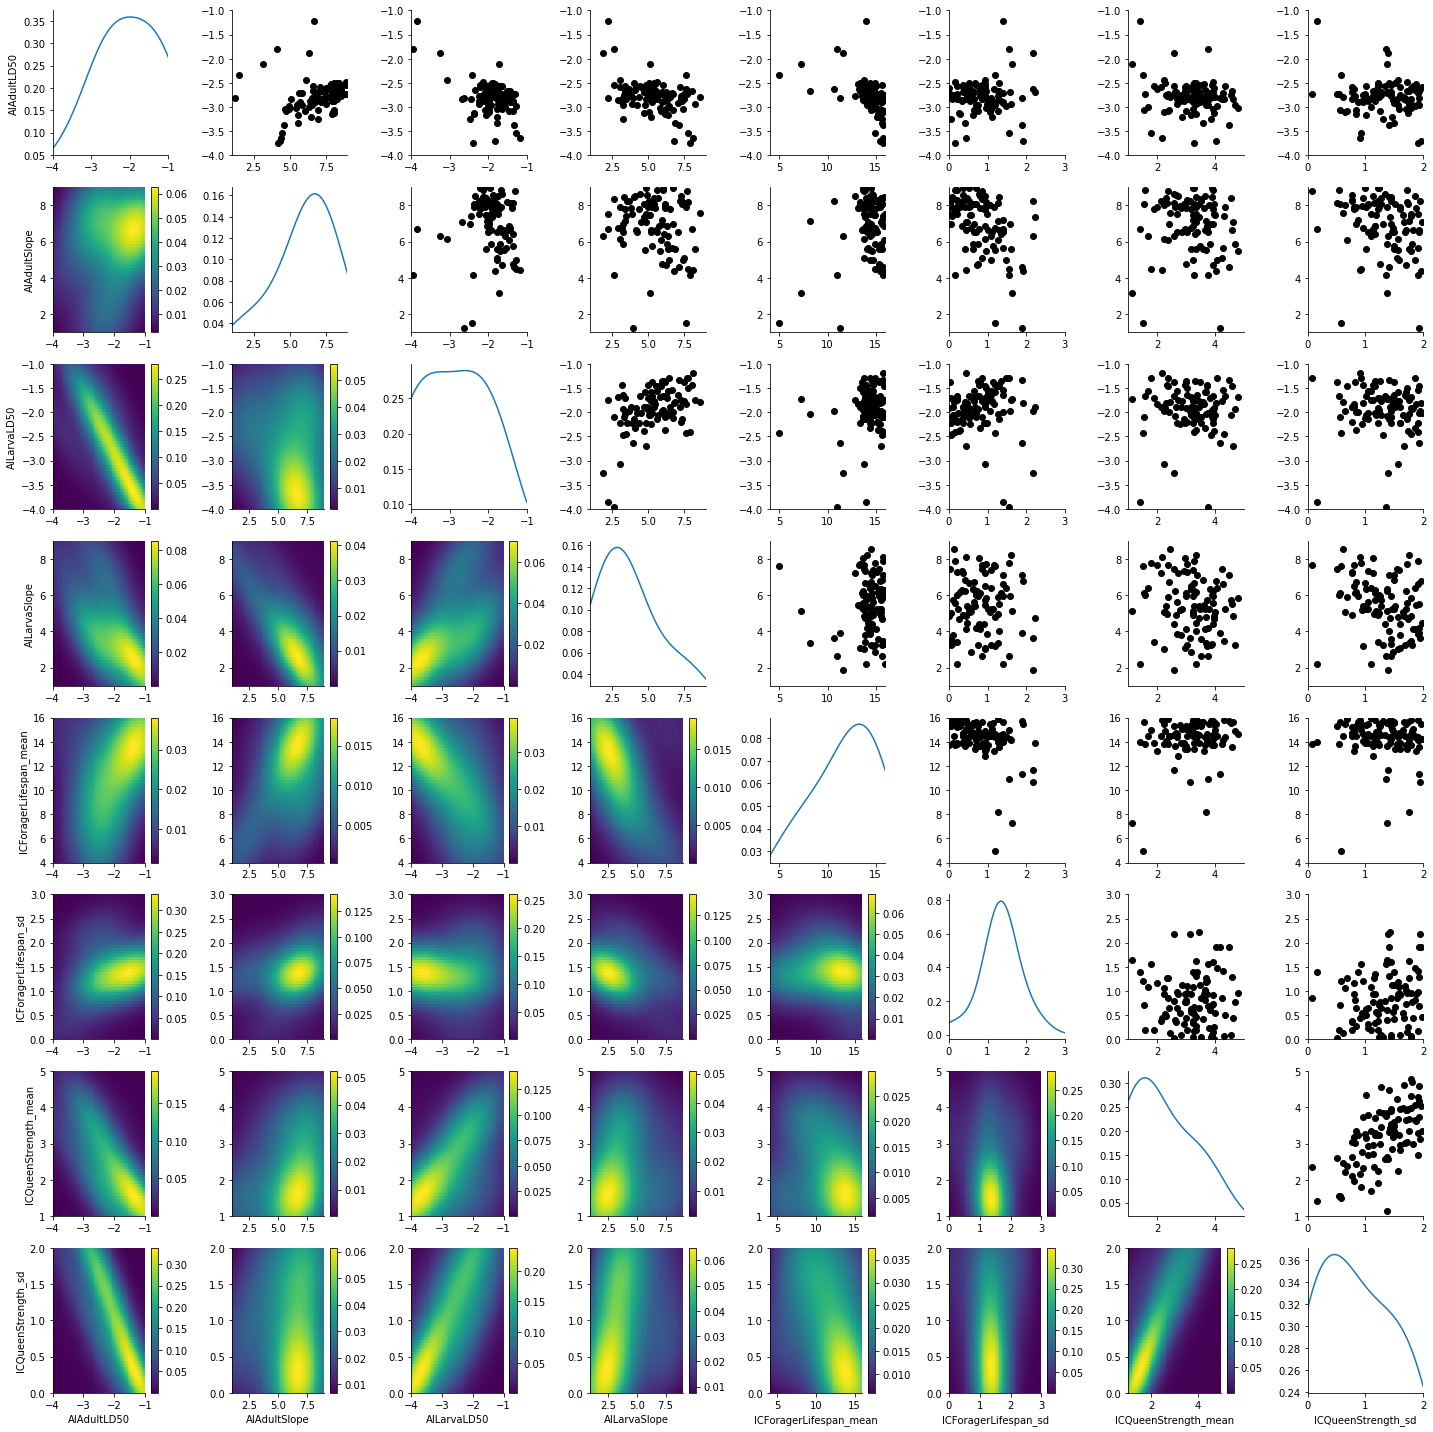

In [42]:
df, w = history.get_distribution(m=0, t=3)
plot_kde_matrix(df, w, limits=limits);

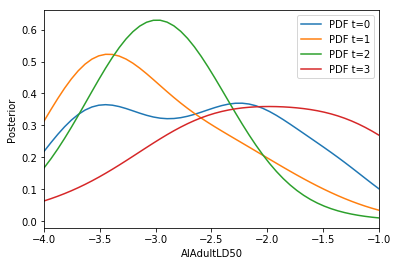

In [38]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=-4, xmax=-1,
                                   x='AIAdultLD50', ax=ax,
                                   label="PDF t={}".format(t))
ax.legend()
plt.show()

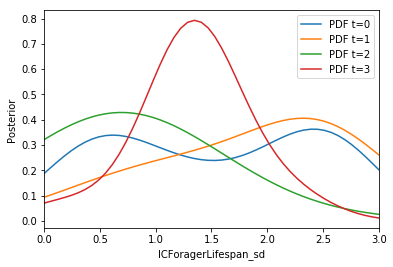

In [48]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=3,
                                   x='ICForagerLifespan_sd', ax=ax,
                                   label="PDF t={}".format(t))
ax.legend()
plt.show()

### Visualize from a stored run

In [34]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_11_20.db"))
history = History(db_path)
history.id = 2

In [21]:
history

In [22]:
df, w = history.get_distribution(m=0, t=3)

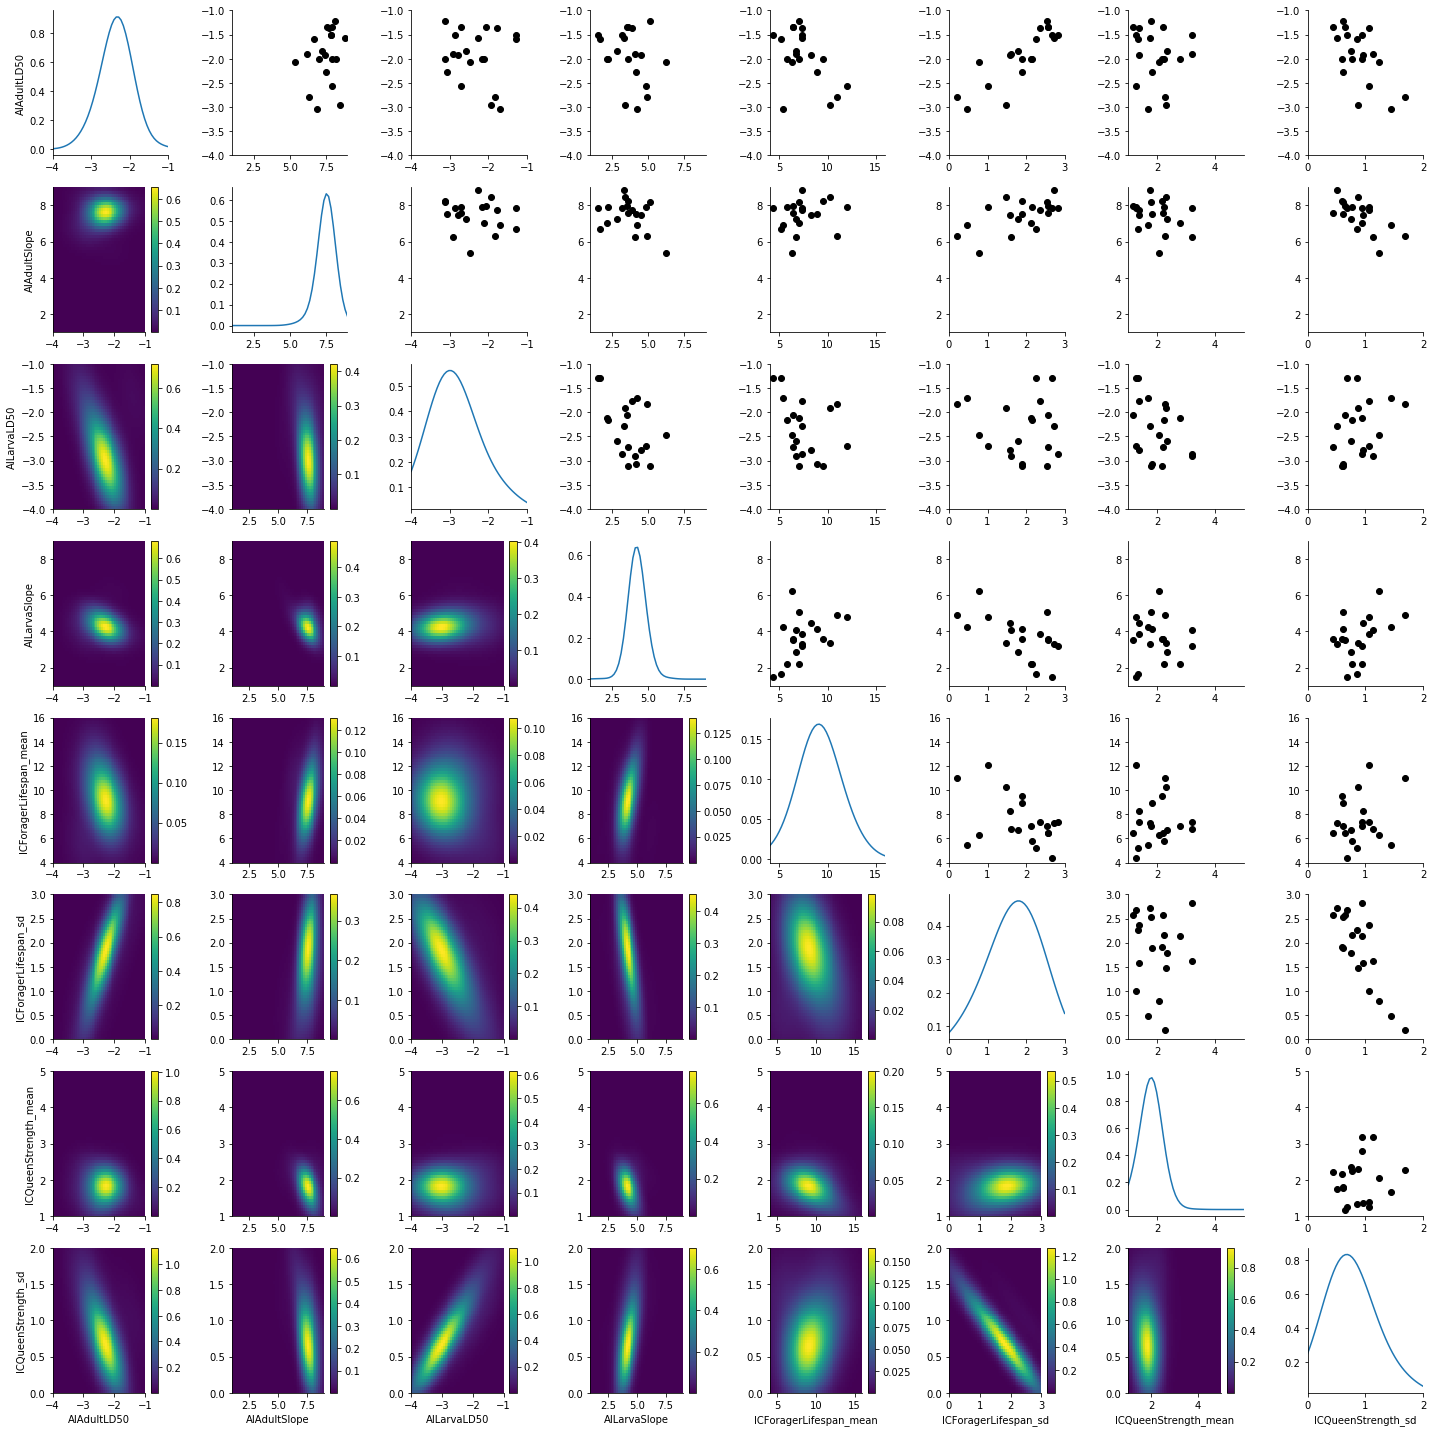

In [23]:
plot_kde_matrix(df, w, limits=limits);

In [45]:
df

name,AIAdultLD50,AIAdultSlope,AILarvaLD50,AILarvaSlope,ICForagerLifespan_mean,ICForagerLifespan_sd,ICQueenStrength_mean,ICQueenStrength_sd
id,,,,,,,,
303,-2.685636,8.094345,-1.772840,5.406513,14.553191,0.657079,3.449022,1.267300
304,-2.663545,6.648187,-1.451895,5.516439,13.541263,1.298367,4.598010,1.923057
305,-2.829690,5.112503,-1.767447,7.463796,13.834600,0.846625,4.239668,1.554032
306,-2.582455,7.101485,-2.014743,4.465162,14.222965,0.471162,3.354573,1.982290
307,-2.842316,7.089738,-2.690495,4.839774,15.594149,0.451034,4.609429,1.665724
308,-2.635456,7.884031,-1.836026,7.646172,13.272350,1.156771,1.976554,0.801624
309,-2.508028,8.440665,-2.146109,3.999631,14.399742,1.306812,3.333596,1.412176
310,-2.841345,6.523990,-1.562820,5.604397,14.675542,0.643028,2.680901,1.041421
311,-2.798456,7.773063,-2.223311,4.389313,14.535816,0.919606,3.942047,1.605260


In [25]:
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-20 15:23:14.100306,0,0.000000,1
1,0,2018-11-20 15:38:08.153725,44,52986.050714,20
2,1,2018-11-20 15:49:16.841928,57,48896.546102,20
3,2,2018-11-20 16:00:42.446527,62,49100.309911,20
4,3,2018-11-20 16:08:37.402428,49,55247.677388,20


In [26]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-19 09:48:44.237618, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-11-19 10:16:00.313808, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-11-19 10:47:32.331211, end_time=None)>,
 <ABCSMC(id=4, start_time=2018-11-19 10:55:29.405699, end_time=None)>,
 <ABCSMC(id=5, start_time=2018-11-19 10:58:12.539482, end_time=2018-11-19 11:04:46.744872)>,
 <ABCSMC(id=6, start_time=2018-11-19 11:14:13.248036, end_time=2018-11-19 11:25:44.451251)>,
 <ABCSMC(id=7, start_time=2018-11-19 11:34:52.601518, end_time=None)>,
 <ABCSMC(id=8, start_time=2018-11-19 11:37:28.154822, end_time=None)>,
 <ABCSMC(id=9, start_time=2018-11-19 12:02:46.222771, end_time=None)>,
 <ABCSMC(id=10, start_time=2018-11-19 12:49:26.291791, end_time=2018-11-19 13:05:23.635283)>,
 <ABCSMC(id=11, start_time=2018-11-19 13:14:18.630738, end_time=2018-11-19 13:56:03.907584)>,
 <ABCSMC(id=12, start_time=2018-11-19 14:14:07.649077, end_time=2018-11-19 14:57:20.148570)>,
 <ABCSMC(id=13, start_time=2018-11-

In [66]:
#get the maximum a posteriori estimation for AdultLD50
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
MAP.item()

-1.9847975749257327

In [79]:
#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
x.item(np.min(np.where(cdf > .5)))

-2.249545797086647

In [43]:
np.median(df['AIAdultLD50']), np.mean(df['AIAdultLD50'])

(-2.780765947504524, -2.789874327890713)

In [44]:
np.median(df['AILarvaLD50']), np.mean(df['AILarvaLD50'])

(-1.8909953208346306, -1.9243347164573175)